In [16]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

In [2]:
data = pd.read_csv('Electric_Production.csv',index_col=0)
data.index = pd.to_datetime(data.index)
data.columns = ['Energy Production']

data.head()

,Energy Production
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


84


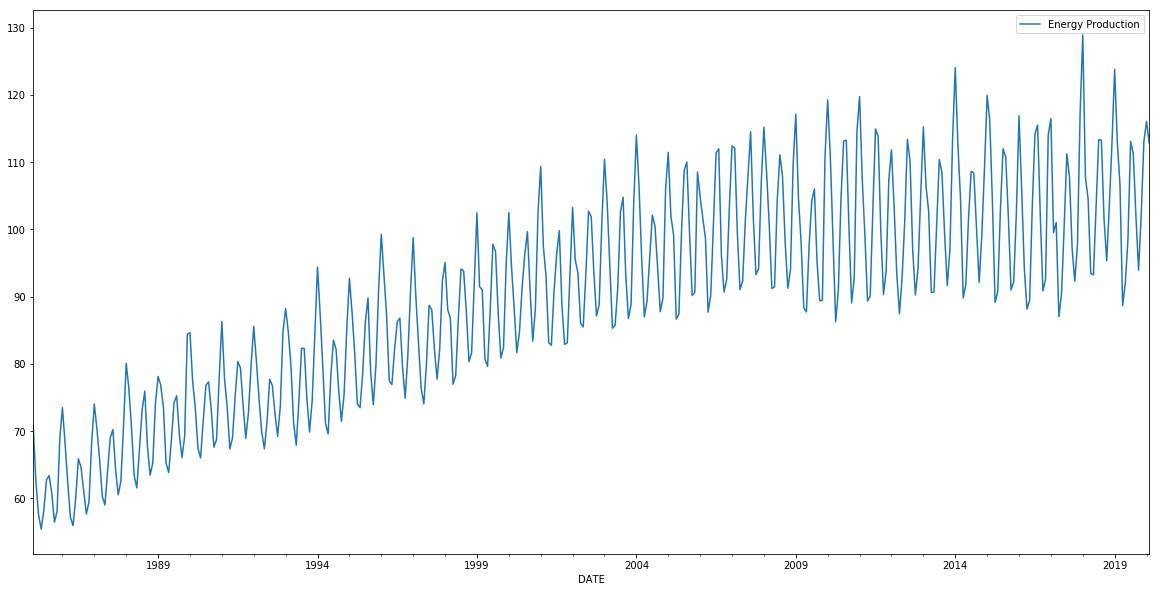

In [24]:
graph_start_date = '01-01-1985'
graph_size = (20,10)

graph_df = data.loc[data.index > graph_start_date]

graph_df.plot(figsize=graph_size)


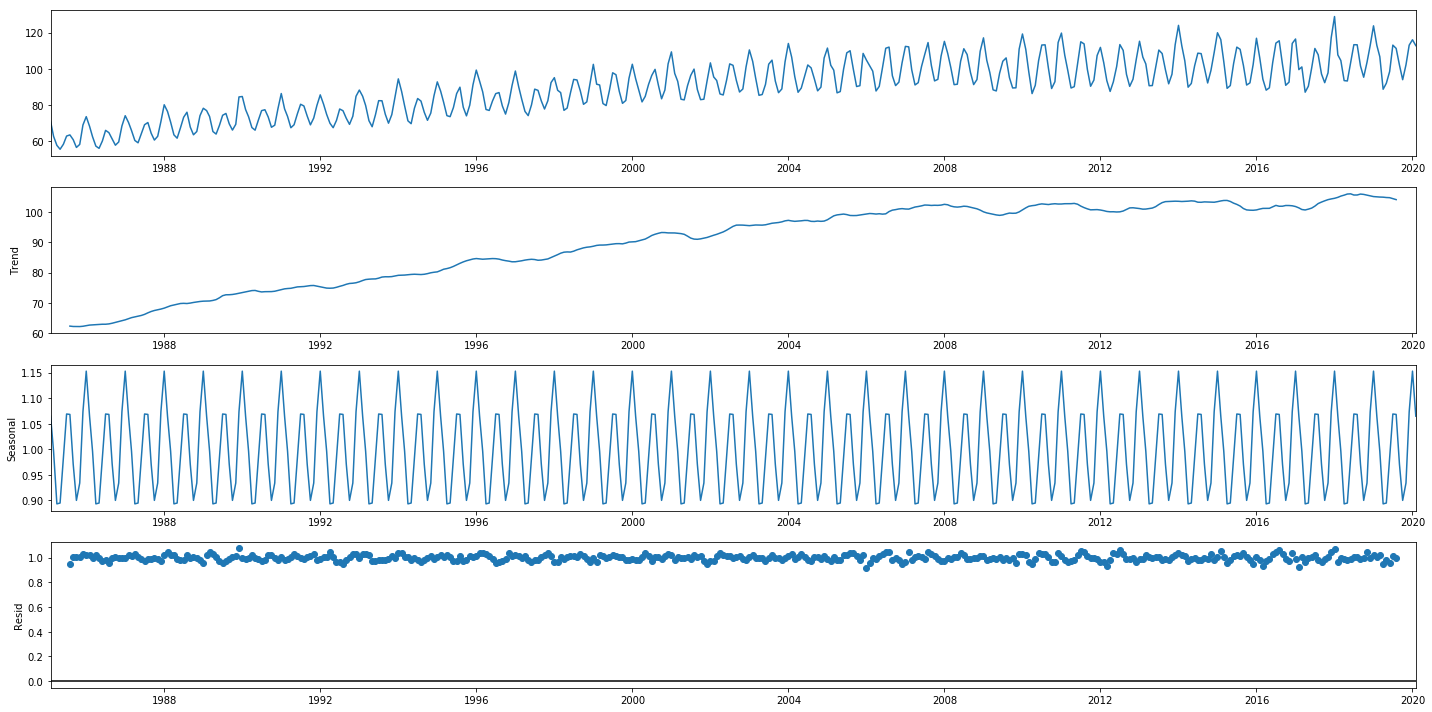

In [4]:
with mpl.rc_context():
    mpl.rc("figure", figsize=graph_size)
    result = seasonal_decompose(graph_df, model='multiplicative')
    seasonal_plot = result.plot()

In [125]:
# train on x% of the data after 1985
train_proportion = 0.9
train_set_size = int(graph_df.count() * train_proportion)
test_set_size = int(graph_df.count() - train_set_size)

train, test = pm.model_selection.train_test_split(graph_df, train_size=train_set_size)


# Fit a simple auto_arima model
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 12) (constant=True); AIC=1832.796, BIC=1864.254, Time=0.462 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=2609.174, BIC=2617.039, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=1927.607, BIC=1943.336, Time=0.232 seconds
Near non-invertible roots for order (1, 1, 0)(1, 0, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=2263.247, BIC=2278.976, Time=0.230 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=2607.259, BIC=2611.191, Time=0.009 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 1, 12) (constant=True); AIC=1946.913, BIC=1974.439, Time=0.419 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 0, 12) (constant=True); AIC=1935.989, BIC=1963.515, Time=0.402 seconds
Fit ARIMA: (2, 1, 2)x(2, 0, 1, 12) (constant=True); AIC=1842.984, BIC=1878.374, Time=1.481 seconds
Fit A

In [126]:
print(arima)

future_forecast, conf_int = arima.predict(n_periods=test_set_size, return_conf_int=True)

conf_int_df = pd.DataFrame(conf_int, columns = ['Lower', 'Upper'], index = test.index)

print(conf_int_df)

print(future_forecast)


ARIMA(maxiter=10, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)
                 Lower       Upper
DATE                              
2016-08-01  105.700558  115.343302
2016-09-01   94.246903  106.145695
2016-10-01   85.771395   97.979540
2016-11-01   88.708030  101.268541
2016-12-01   99.566954  112.858228
2017-01-01  110.528899  124.540300
2017-02-01  101.080214  115.647497
2017-03-01   90.568147  105.649238
2017-04-01   81.840871   97.453839
2017-05-01   83.609690   99.747998
2017-06-01   95.109036  111.746354
2017-07-01  104.119807  121.237086
2017-08-01  100.332284  119.752296
2017-09-01   90.236101  111.148030
2017-10-01   81.881733  103.503706
2017-11-01   85.294574  107.632909
2017-12-01   95.229208  118.453612
2018-01-01  105.632320  129.722838
2018-02-01   97.348406  122.214682
2018-03-01   87.501792  113.109699

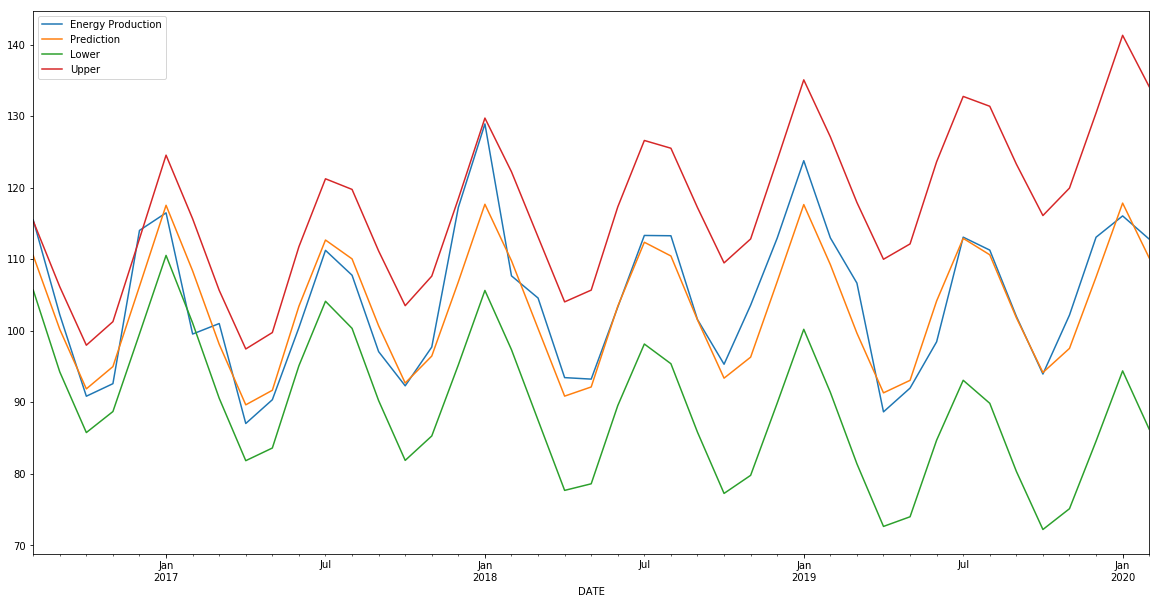

In [127]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast, conf_int_df['Lower'], conf_int_df['Upper']],axis=1).plot(figsize=graph_size)

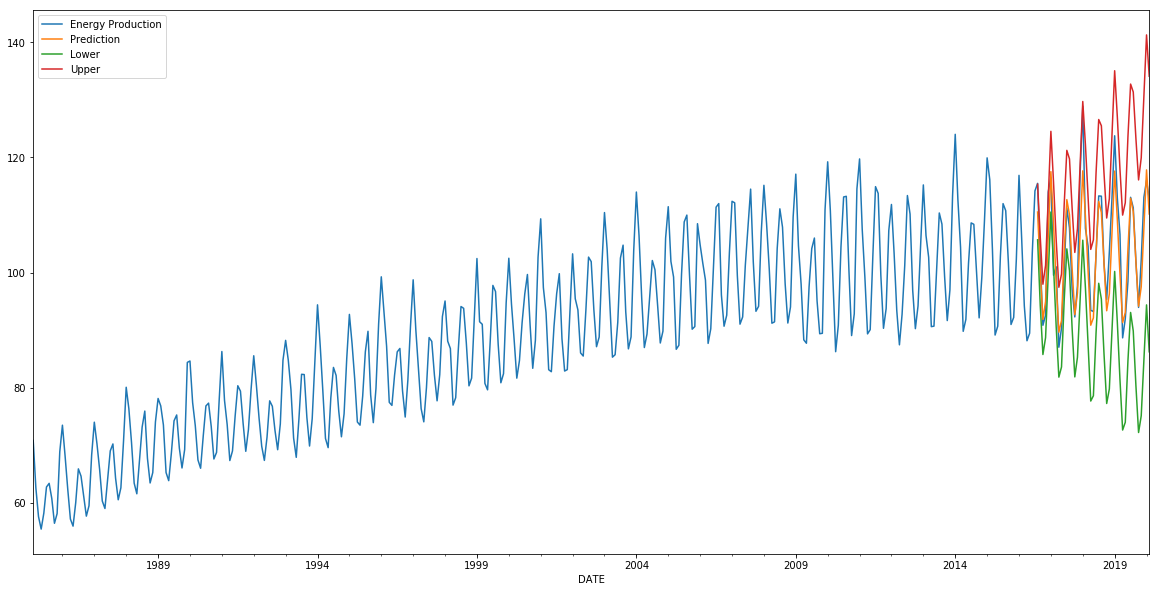

In [128]:
pd.concat([graph_df,future_forecast, conf_int_df['Lower'], conf_int_df['Upper']],axis=1).plot(figsize=graph_size)

In [129]:
next_best_arima = pm.ARIMA(order=(4, 1, 2),
                  seasonal_order=(2, 0, 2, 12),
                  suppress_warnings=True)


cv = pm.model_selection.SlidingWindowForecastCV(window_size=75, step=30, h=1)

arima_cv_scores = pm.model_selection.cross_val_score(
    arima, train, scoring='smape', cv=cv, verbose=2)

next_best_arima_cv_scores = pm.model_selection.cross_val_score(
    next_best_arima, train, scoring='smape', cv=cv, verbose=2)


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] f

In [130]:
print("best auto model CV scores: {}".format(arima_cv_scores.tolist()))
print("2nd best auto model CV scores: {}".format(next_best_arima_cv_scores.tolist()))

best auto model CV scores: [3.158188857414473, 1.731282121399723, 0.8102446516829169, 2.8657350636078167, 3.1554343009410712, 0.8695901836796022, 1.2866557223899302, 2.136190190528935, 3.1642007776957417, 2.9033385875645514, 5.412166905692479]
2nd best auto model CV scores: [4.863152475716209, 2.5344253193217474, 0.1067184776873707, 4.0665515290751975, 1.3919447642258775, 1.0115711867762733, 2.1254086224345303, 2.2092365597183017, 2.504837451379491, 4.344228155184397, 1.6159119456160462]


In [131]:
arima_average_error = np.average(arima_cv_scores)
arima_next_best_average_error = np.average(next_best_arima_cv_scores)
errors = [arima_average_error, arima_next_best_average_error]
errors = [round(e,3) for e in errors]
models = [arima, next_best_arima]

print([f"error = {e}%" for e in errors])

# print out the answer
better_index = np.argmin(errors)  # type: int
print(f"Lowest average SMAPE: {errors[better_index]}% (model{better_index + 1})")
print(f"Best model: {models[better_index]}")

['error = 2.499%', 'error = 2.434%']
Lowest average SMAPE: 2.434% (model2)
Best model: ARIMA(maxiter=50, method='lbfgs', order=(4, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)


In [132]:
next_best_arima.fit(train)

future_forecast, conf_int = next_best_arima.predict(n_periods=test_set_size, return_conf_int=True)

conf_int_df = pd.DataFrame(conf_int, columns = ['Lower', 'Upper'], index = test.index)

print(conf_int_df )



print(future_forecast)

                 Lower       Upper
DATE                              
2016-08-01  108.183442  117.359040
2016-09-01   95.805092  107.024962
2016-10-01   86.932283   99.115641
2016-11-01   89.526734  102.716495
2016-12-01  103.801428  117.879318
2017-01-01  112.638214  127.706046
2017-02-01  103.812526  120.081213
2017-03-01   93.879157  111.281186
2017-04-01   82.860473  101.118532
2017-05-01   84.188534  103.088949
2017-06-01   95.114260  114.630195
2017-07-01  104.252815  124.518733
2017-08-01  102.911736  124.387330
2017-09-01   91.119203  113.654614
2017-10-01   82.308946  105.644681
2017-11-01   85.450654  109.424619
2017-12-01   99.608569  124.195391
2018-01-01  108.506476  133.830063
2018-02-01  100.003963  126.205218
2018-03-01   90.497307  117.554795
2018-04-01   79.297603  107.043554
2018-05-01   80.303451  108.592577
2018-06-01   91.115999  119.933199
2018-07-01  100.312529  129.763333
2018-08-01   99.438549  129.801476
2018-09-01   87.782613  118.987911
2018-10-01   79.0195

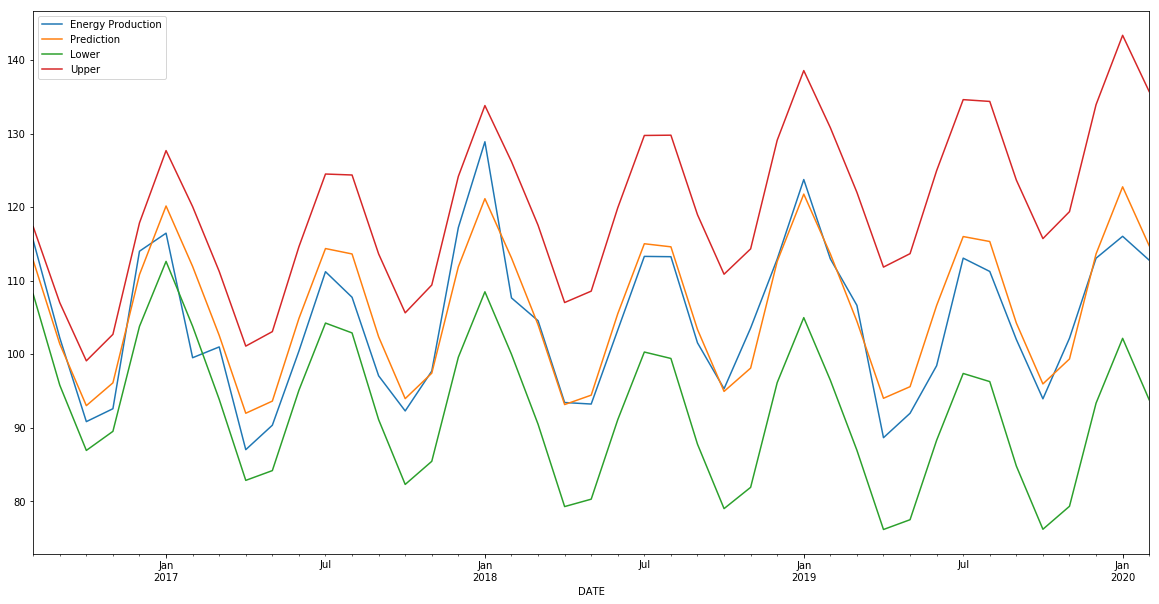

In [134]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast, conf_int_df['Lower'], conf_int_df['Upper']],axis=1).plot(figsize=graph_size)